# Does a County's Population Density Impact the Susceptibility to Mental Health Issues among Individuals age 18 and above in the United States? 

## Introduction

**Specific Problem.** How to identify individuals, based on self-administered substance use, demographics, and geographic information from the National Survey on Drug Use and Health (NSDUH), who are more susceptible to mental health issues?  Identify participants with a binary indicator of 1 (Yes) for ‘Past Month Serious Psychologicial Distress Indicator’ which is derived from a series of six questions known as the K6, asking adults respondents how frequently they experienced symptoms of psychological distress during the past 30 days: 

* How often did you feel nervous?
* How often did you feel hopeless?
* How often did you feel restless or fidgety?
* How often did you feel so sad/depressed that nothing could cheer you up?
* How often did you feel that everything was an effort?
* How often did you feel down on yourself, no good or worthless?


**Analytical Context.**
The Statistical Analysis jupyter notebook will proceed as follows: we will (1) explore the relationship of available features with the interested outcome variable (Any_Mental_Illness_Indicator_Past_Year) using logistic regression; (2) discuss feature engineering (if applicable/need); (3) Bivariate Analysis using Chi-Square/Regression; and (4) Multivariate Analysis with Feature Selection (Forward/Backward/Mixed/other methods) to study the importance of other features in relation to our interested outcome variable.

**Hypothesis**
H_0: Metropolitan Status and Susceptibility to Mental Health Issues are independent
H_A: Metropolitan Status and Susceptibility to Mental Health Issues are not independent

In [69]:
# import libraries we will be using:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import pingouin
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Adjust notebook settings to widen the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:85% !important;}</style>"))
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [73]:
# read in the data
df = pd.read_csv("./Data/nsduh_data_cleaned.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
print('NSDUH Data Shape: {}'.format(df.shape))

X = df.drop(['Serious_Psychological_Distress_Indicator_Past_Month', 'Id'], axis=1) # exclude independent variables + Id data
y = df['Serious_Psychological_Distress_Indicator_Past_Month']  # only include dependent variable data

X.shape, y.shape # print X and y's data shape

NSDUH Data Shape: (214505, 95)


((214505, 93), (214505,))

In [74]:
df.head()

,Id,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Treatment_Type_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Gender,Age_Category,Age_Category_Two_Levels,Age_Category_Three_Levels,Age_Category_Six_Levels,Gender_Age_Category,Race_Ethnicity,Race_Sex,Education_Category,Overall_Health,Work_Situation_Past_Week,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Adult_Employment_Status,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Total_Income_Family,Participated_In_One_Or_More_Government_Assistance_Programs,Total_Income_Family_Recode,Poverty_Level,PDEN10,County_Metro_NonMetro_Status
0,13005143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,4,3,4,4,5,7,5,2,1,1,0,0,1,0,1,0,0,-1,1,1,0,0,1,0,1,1,2,4,1,2,2,2,2
1,67415143,2015,0,1,1,1,6,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,0,0,11,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,3,3,3,3,5,1,2,4,2,7,0,-1,4,0,0,0,1,-1,1,1,0,0,0,0,0,0,1,1,0,1,1,2,3
2,75235143,2015,0,1,1,1,6,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,6,0,-1,11,0,0,0,0,0,0,1,1,1,0,0,0,0,0,-1,2,2,2,2,2,4,1,2,3,3,6,0,-1,4,0,0,0,1,-1,1,1,0,0,0,0,0,0,1,2,0,1,1,3,3
3,47745143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,8,0,0,0,0,0,0,1,1,1,0,0,0,0,0,-1,1,2,2,2,2,3,5,7,3,3,7,0,-1,4,0,0,0,1,-1,1,1,0,0,0,0,0,0,1,1,0,1,1,1,1
4,33145143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,2,2,2,2,3,7,5,2,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0,2,3,2,2


In [75]:
df["Serious_Psychological_Distress_Indicator_Past_Month"].value_counts()

# 0    197059
# 1     17446

0    197059
1     17446
Name: Serious_Psychological_Distress_Indicator_Past_Month, dtype: int64

Target class has two classes: 
* 1 (Has indication of serious psychological distress indicator past month) = 17,446 people
* 0 (Has no indication of serious psychological distress indicator past month) = 197,059 people

# Bivariate Analysis

In [103]:
df_contingency_table = pd.crosstab(index=df["Serious_Psychological_Distress_Indicator_Past_Month"], columns=df["PDEN10"], normalize="columns")*100
df_contingency_table

PDEN10,1,2,3
Serious_Psychological_Distress_Indicator_Past_Month,,,
0,92.317209,91.47192,91.915849
1,7.682791,8.52808,8.084151


## Overview of the Chi-Square Test of Independence

The Chi-square test of association evaluates relationships between categorical variables. Like any statistical hypothesis test, the Chi-square test has both a null hypothesis and an alternative hypothesis.

* Null hypothesis: There are no relationships between the categorical variables. If you know the value of one variable, it does not help you predict the value of another variable.
* Alternative hypothesis: There are relationships between the categorical variables. Knowing the value of one variable does help you predict the value of another variable.

In [86]:
ALPHA005 = 0.05
ALPHA001 = 0.01

In [98]:
observed_values = pd.crosstab(df.Serious_Psychological_Distress_Indicator_Past_Month, df.PDEN10).values
chi2, p, dof, expected_values = chi2_contingency(observed_values)
chi2, p, dof, expected_values

(47.02696062156092,
 6.140804208431684e-11,
 2,
 array([[83905.67448777, 97607.61609753, 15545.7094147 ],
        [ 7428.32551223,  8641.38390247,  1376.2905853 ]]))

In [87]:
observed_values = pd.crosstab(df.Serious_Psychological_Distress_Indicator_Past_Month, df.PDEN10).values
chi2, p, dof, expected_values = chi2_contingency(observed_values)
chi2, p, dof, expected_values

outcome = 'Serious_Psychological_Distress_Indicator_Past_Month'
indicator = 'Population Density'

if p <= ALPHA001:
    print(f'Rejected H0 under significance level {ALPHA001}, {outcome} & {indicator} are dependent.')
else:
    print(f'Fail to reject H0 due to lack of evidence under significance level {ALPHA001} {outcome} & {indicator} are independent.')

Rejected H0 under significance level 0.01, Serious_Psychological_Distress_Indicator_Past_Month & Population Density are dependent.


In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection

df_cat_label =  pd.concat([df.loc[:, ['Inpatient_Past_Year', 'Outpatient_Past_Year',
                                       'Prescription_Treatment_Past_Year', 'Any_Treatment_Past_Year',
                                       'Treatment_Type_Past_Year', 'Perceived_Unmet_Need',
                                       'Received_Treatment_At_Clinic_Or_Center',
                                       'Received_Treatment_At_Private_Therapist',
                                       'Received_Treatment_At_NonClinic_Doctor',
                                       'Received_Treatment_At_Medical_Clinic',
                                       'Received_Treatment_At_Day_Hospital', 'Received_Treatment_At_School',
                                       'Received_Treatment_Other', 'Self_Paid', 'Non_Household_Member_Paid',
                                       'Private_Health_Insurance_Paid', 'Medicare_Paid', 'Medicaid_Paid',
                                       'Rehab_Paid', 'Employer_Paid', 'Military_Paid',
                                       'Other_Public_Source_Paid', 'Other_Private_Source_Paid', 'Nobody_Paid',
                                       'No_Treatment_Could_Not_Afford',
                                       'No_Treatment_Feared_Neighbors_Opinion',
                                       'No_Treatment_Feared_Effect_On_Job',
                                       'No_Treatment_Insurance_Not_Covered',
                                       'No_Treatment_Insurance_Not_Covered_Enough', 'No_Treatment_Where_To_Go',
                                       'No_Treatment_Confidentiality_Concerns',
                                       'No_Treatment_Fear_Of_Being_Committed',
                                       'No_Treatment_Didnt_Think_Needed',
                                       'No_Treatment_Handle_Problem_Without',
                                       'No_Treatment_No_Transport_Inconvenient', 'No_Treatment_Other',
                                       'Num_Weeks_Mental_Health_Difficulties',
                                       'Num_Days_Past_Year_Unable_To_Work',
                                       'Psychological_Distress_Level_Worst_Month',
                                       'Worst_Psychological_Distress_Level',
                                       'Serious_Psychological_Distress_Indicator_Past_Year',
                                       'Serious_Psychological_Distress_Indicator_Past_Month',
                                       'Serious_Suicidal_Thoughts_Past_Year', 'Suicide_Plan_Past_Year',
                                       'Suicide_Attempt_Past_Year',
                                       'Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year',
                                       'Moderate_Mental_Illness_Indicator_Past_Year',
                                       'Mild_Mental_Illness_Indicator_Past_Year',
                                       'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year',
                                       'Categorical_Mental_Illness_Indicator',
                                       'Serious_Mental_Illness_And_Substance_Abuse',
                                       'Any_Mental_Illness_And_Substance_Abuse',
                                       'Low_Or_Moderate_Mental_Illness_And_Substance_Abuse',
                                       'Adult_Lifetime_Major_Depressive_Episode',
                                       'Adult_Past_Year_Major_Depressive_Episode',
                                       'Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year',
                                       'Gender', 'Age_Category', 'Age_Category_Six_Levels',
                                       'Gender_Age_Category', 'Race_Ethnicity', 'Race_Sex', 'Education_Category',
                                       'Overall_Health', 'Work_Situation_Past_Week',
                                       'Num_Days_Skipped_Work_Past_30_Days', 'EAP_Offered',
                                       'Adult_Employment_Status', 'Has_Medicare', 'Has_Medicaid_Or_CHIP',
                                       'Has_Military_Benefit', 'Has_Private_Health_Insurance',
                                       'Has_Other_Health_Insurance', 'Covered_By_Any_Health_Insurance',
                                       'Covered_By_Any_Health_Insurance_Imputation_Revised',
                                       'Family_Receives_Social_Security', 'Family_Receives_SSI',
                                       'Family_Receives_Food_Stamps', 'Family_Receives_Public_Assistance',
                                       'Family_Receives_Welfare_JobPlacement_Childcare', 'Months_On_Welfare',
                                       'Total_Income_Respondent', 'Total_Income_Family',
                                       'Participated_In_One_Or_More_Government_Assistance_Programs',
                                       'Total_Income_Family_Recode', 'Poverty_Level',
                                       'PDEN10', 'County_Metro_NonMetro_Status',]].apply(lambda x: LabelEncoder().fit_transform(x)),
                           df.loc[: , 'Adult_Employment_Status':'Worst_Psychological_Distress_Level']], axis=1)

df_cat_label.head()

,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Treatment_Type_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Psychological_Distress_Indicator_Past_Month,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Gender,Age_Category,Age_Category_Six_Levels,Gender_Age_Category,Race_Ethnicity,Race_Sex,Education_Category,Overall_Health,Work_Situation_Past_Week,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Adult_Employment_Status,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Total_Income_Family,Participated_In_One_Or_More_Government_Assistance_Programs,Total_Income_Family_Recode,Poverty_Level,PDEN10,County_Metro_NonMetro_Status
0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,2,2,2,6,4,1,1,1,1,1,0,0,1,0,0,0,2,1,0,0,1,0,1,1,1,3,1,1,2,1,1
1,1,2,2,2,7,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1,12,11,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,2,0,1,3,2,7,1,0,3,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,1,1,2
2,1,2,2,2,7,1,1,1,1,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4,7,0,11,0,0,1,1,1,0,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,1,2,3,6,1,0,3,0,0,0,1,0,2,1,0,0,0,0,0,0,0,1,0,0,1,2,2
3,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,8,0,0,1,1,1,0,0,1,1,1,0,0,0,1,1,0,0,0,0,0,4,6,2,3,7,1,0,3,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,6,4,1,2,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3,3,0,1,3,1,1


In [84]:
chi2_res = feature_selection.chi2(df_cat_label, df.Serious_Psychological_Distress_Indicator_Past_Month)

df_chi2 = pd.DataFrame({
    'attr1': 'Serious_Psychological_Distress_Indicator_Past_Month',
    'attr2': df_cat_label.columns,
    'chi2': chi2_res[0],
    'p': chi2_res[1],
    'alpha': ALPHA001
})

df_chi2['H0'] = df_chi2.p.apply(lambda x: 'rejected' if x <= ALPHA001 else 'fail to reject')
df_chi2['relation'] = df_chi2.H0.apply(lambda x: 'dependent' if x=='rejected' else 'independent')

df_chi2

,attr1,attr2,chi2,p,alpha,H0,relation
0,Serious_Psychological_Distress_Indicator_Past_...,Inpatient_Past_Year,4.819148e+01,3.865640e-12,0.01,rejected,dependent
1,Serious_Psychological_Distress_Indicator_Past_...,Outpatient_Past_Year,7.046586e+02,2.901859e-155,0.01,rejected,dependent
2,Serious_Psychological_Distress_Indicator_Past_...,Prescription_Treatment_Past_Year,1.093433e+03,8.834478e-240,0.01,rejected,dependent
3,Serious_Psychological_Distress_Indicator_Past_...,Any_Treatment_Past_Year,1.474970e+03,0.000000e+00,0.01,rejected,dependent
4,Serious_Psychological_Distress_Indicator_Past_...,Treatment_Type_Past_Year,2.233203e+04,0.000000e+00,0.01,rejected,dependent
5,Serious_Psychological_Distress_Indicator_Past_...,Perceived_Unmet_Need,1.728879e+03,0.000000e+00,0.01,rejected,dependent
6,Serious_Psychological_Distress_Indicator_Past_...,Received_Treatment_At_Clinic_Or_Center,1.119006e+02,3.756837e-26,0.01,rejected,dependent
7,Serious_Psychological_Distress_Indicator_Past_...,Received_Treatment_At_Private_Therapist,1.931474e+02,6.536532e-44,0.01,rejected,dependent
8,Serious_Psychological_Distress_Indicator_Past_...,Received_Treatment_At_NonClinic_Doctor,1.961203e+01,9.487012e-06,0.01,rejected,dependent
9,Serious_Psychological_Distress_Indicator_Past_...,Received_Treatment_At_Medical_Clinic,4.025013e+00,4.483027e-02,0.01,fail to reject,independent


In [85]:
df_chi2[df_chi2['p']<=0.01]['attr2'] #features that show statistical significance with serious_psychological_distress_indicator_past_month

0                                   Inpatient_Past_Year
1                                  Outpatient_Past_Year
2                      Prescription_Treatment_Past_Year
3                               Any_Treatment_Past_Year
4                              Treatment_Type_Past_Year
5                                  Perceived_Unmet_Need
6                Received_Treatment_At_Clinic_Or_Center
7               Received_Treatment_At_Private_Therapist
8                Received_Treatment_At_NonClinic_Doctor
13                                            Self_Paid
14                            Non_Household_Member_Paid
15                        Private_Health_Insurance_Paid
16                                        Medicare_Paid
17                                        Medicaid_Paid
18                                           Rehab_Paid
19                                        Employer_Paid
20                                        Military_Paid
21                             Other_Public_Sour

In [114]:
from platform import python_version

print(python_version())

3.8.8


In [104]:
df_chi2[df_chi2['p']>0.01]['attr2'] # drop these from the multicollinearity test

9     Received_Treatment_At_Medical_Clinic
10      Received_Treatment_At_Day_Hospital
11            Received_Treatment_At_School
12                Received_Treatment_Other
60                          Race_Ethnicity
70                    Has_Military_Benefit
75         Family_Receives_Social_Security
Name: attr2, dtype: object

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


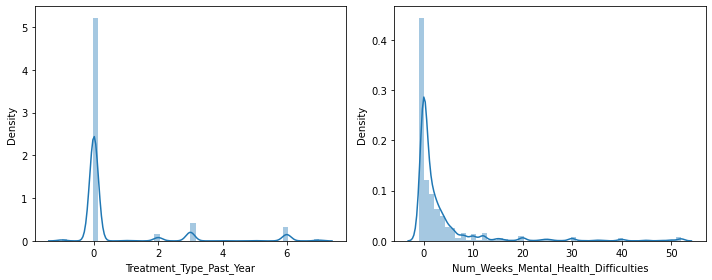

In [93]:
fig = plt.figure(1, (10, 4))

ax = plt.subplot(1,2,1)
sns.distplot(df.Treatment_Type_Past_Year)
plt.tight_layout()

ax = plt.subplot(1,2,2)
sns.distplot(df.Num_Weeks_Mental_Health_Difficulties)
plt.tight_layout()

plt.show()

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


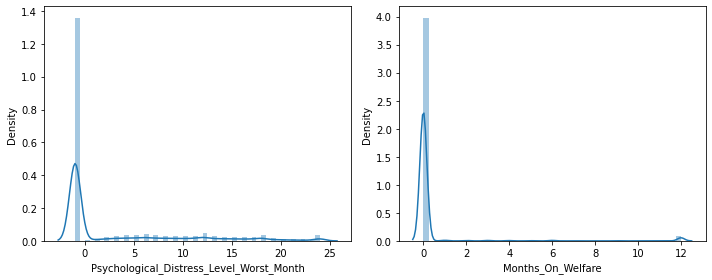

In [94]:
fig = plt.figure(1, (10, 4))

ax = plt.subplot(1,2,1)
sns.distplot(df.Psychological_Distress_Level_Worst_Month)
plt.tight_layout()


ax = plt.subplot(1,2,2)
sns.distplot(df.Months_On_Welfare)
plt.tight_layout()

plt.show()

# Multivariate Analysis & Multicollinearity

**Multicollinearity** (or collinearity) occurs when one independent variable in a regression model is linearly correlated with another independent variable.

**Problems That Arise From Multicollinearity**

1. The fitted regression coefficients (beta hat) will change substantially if one of the values of one of the x variables is changed only a bit.

2. The variance of the estimated coefficients will be inflated, which means that it will be hard to detect statistical significance. Furthermore, it’s possible that the F statistic is significant but the individual t statistics are not.

3. Ultimately, multicollinearity makes prediction less accurate. For a given model, the underlying assumption is that the relationships among the predicting variables, as well as their relationship with the target variable, will be the same. However, when multicollinearity is present, this is less likely to be the case.

**How to Detect and Eliminate Multicollinearity** Variance inflation factor or the IVF for each predicting variable. A VIF of 1 (the minimum possible VIF) means the tested predictor is not correlated with the other predictors.A VIF of 1 (the minimum possible VIF) means the tested predictor is not correlated with the other predictors.An acceptable VIF is if it’s less than the max of 10 and 1/1-R²model.

In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [105]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]


X1 = X.drop(['Received_Treatment_At_Medical_Clinic',
             'Received_Treatment_At_Day_Hospital',
             'Received_Treatment_At_School',
             'Received_Treatment_Other',
             'Race_Ethnicity',
             'Has_Military_Benefit', 
             'Family_Receives_Social_Security'], axis=1)
vif_data1 = pd.DataFrame()
vif_data1["feature"] = X1.columns
vif_data1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]
vif_data1.sort_values(by='VIF', ascending=False)

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
49,Serious_Mental_Illness_And_Substance_Abuse,inf
48,Categorical_Mental_Illness_Indicator,inf
47,Low_Or_Moderate_Mental_Illness_Indicator_Past_...,inf
46,Mild_Mental_Illness_Indicator_Past_Year,inf
45,Moderate_Mental_Illness_Indicator_Past_Year,inf
44,Serious_Or_Moderate_Mental_Illness_Indicator_P...,inf
51,Low_Or_Moderate_Mental_Illness_And_Substance_A...,inf
50,Any_Mental_Illness_And_Substance_Abuse,inf
15,Rehab_Paid,2824.704219
58,Age_Category_Three_Levels,899.092336


In [108]:
list(vif_data1[vif_data1['VIF']>150]['feature']) # drop these before running the next VIF test
# but keeping these variables: 'Age_Category_Six_Levels'

['Year',
 'Non_Household_Member_Paid',
 'Rehab_Paid',
 'Employer_Paid',
 'Military_Paid',
 'Other_Public_Source_Paid',
 'Other_Private_Source_Paid',
 'Nobody_Paid',
 'No_Treatment_Feared_Effect_On_Job',
 'No_Treatment_Insurance_Not_Covered',
 'No_Treatment_Confidentiality_Concerns',
 'No_Treatment_Didnt_Want_Others_To_Know',
 'No_Treatment_No_Transport_Inconvenient',
 'Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year',
 'Moderate_Mental_Illness_Indicator_Past_Year',
 'Mild_Mental_Illness_Indicator_Past_Year',
 'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year',
 'Categorical_Mental_Illness_Indicator',
 'Serious_Mental_Illness_And_Substance_Abuse',
 'Any_Mental_Illness_And_Substance_Abuse',
 'Low_Or_Moderate_Mental_Illness_And_Substance_Abuse',
 'Age_Category',
 'Age_Category_Two_Levels',
 'Age_Category_Three_Levels',
 'Age_Category_Six_Levels',
 'Gender_Age_Category']

In [110]:
X2 = X1.drop(['Year',
             'Non_Household_Member_Paid',
             'Rehab_Paid',
             'Employer_Paid',
             'Military_Paid',
             'Other_Public_Source_Paid',
             'Other_Private_Source_Paid',
             'Nobody_Paid',
             'No_Treatment_Feared_Effect_On_Job',
             'No_Treatment_Insurance_Not_Covered',
             'No_Treatment_Confidentiality_Concerns',
             'No_Treatment_Didnt_Want_Others_To_Know',
             'No_Treatment_No_Transport_Inconvenient',
             'Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year',
             'Moderate_Mental_Illness_Indicator_Past_Year',
             'Mild_Mental_Illness_Indicator_Past_Year',
             'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year',
             'Categorical_Mental_Illness_Indicator',
             'Serious_Mental_Illness_And_Substance_Abuse',
             'Any_Mental_Illness_And_Substance_Abuse',
             'Low_Or_Moderate_Mental_Illness_And_Substance_Abuse',
             'Age_Category',
             'Age_Category_Two_Levels',
             'Age_Category_Three_Levels',
             'Gender_Age_Category'], axis=1)
vif_data2 = pd.DataFrame()
vif_data2["feature"] = X2.columns
vif_data2["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(len(X2.columns))]
vif_data2.sort_values(by='VIF', ascending=False)

,feature,VIF
20,No_Treatment_Didnt_Think_Would_Help,141.187762
18,No_Treatment_Didnt_Think_Needed,132.800943
22,No_Treatment_Other,117.715373
55,Total_Income_Family,117.514587
14,No_Treatment_Feared_Neighbors_Opinion,105.705713
15,No_Treatment_Insurance_Not_Covered_Enough,105.137038
17,No_Treatment_Fear_Of_Being_Committed,98.960046
19,No_Treatment_Handle_Problem_Without,87.112915
21,No_Treatment_Didnt_Have_Time,85.512546
57,Total_Income_Family_Recode,81.360202


In [112]:
list(vif_data2[vif_data2['VIF']>10]['feature']) # will drop these variables for the next VIF test
# but keeping these: 
# Treatment_Type_Past_Year, Gender, Age_Category_Six_Levels, 
# Education_Category, Adult_Employment_Status
# Covered_By_Any_Health_Insurance_Imputation_Revised, 
# otal_Income_Family_Recode, Poverty_Level, PDEN10

['Outpatient_Past_Year',
 'Prescription_Treatment_Past_Year',
 'Any_Treatment_Past_Year',
 'Treatment_Type_Past_Year',
 'Perceived_Unmet_Need',
 'Self_Paid',
 'Private_Health_Insurance_Paid',
 'Medicare_Paid',
 'Medicaid_Paid',
 'No_Treatment_Could_Not_Afford',
 'No_Treatment_Feared_Neighbors_Opinion',
 'No_Treatment_Insurance_Not_Covered_Enough',
 'No_Treatment_Where_To_Go',
 'No_Treatment_Fear_Of_Being_Committed',
 'No_Treatment_Didnt_Think_Needed',
 'No_Treatment_Handle_Problem_Without',
 'No_Treatment_Didnt_Think_Would_Help',
 'No_Treatment_Didnt_Have_Time',
 'No_Treatment_Other',
 'Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year',
 'Gender',
 'Age_Category_Six_Levels',
 'Education_Category',
 'Work_Situation_Past_Week',
 'Adult_Employment_Status',
 'Has_Private_Health_Insurance',
 'Has_Other_Health_Insurance',
 'Covered_By_Any_Health_Insurance',
 'Covered_By_Any_Health_Insurance_Imputation_Revised',
 'Total_Income_Family',
 'Total_Income_Family_Recode',
 'Pover

In [113]:
X3 = X2.drop(['Outpatient_Past_Year',
             'Prescription_Treatment_Past_Year',
             'Any_Treatment_Past_Year',
             'Perceived_Unmet_Need',
             'Self_Paid',
             'Private_Health_Insurance_Paid',
             'Medicare_Paid',
             'Medicaid_Paid',
             'No_Treatment_Could_Not_Afford',
             'No_Treatment_Feared_Neighbors_Opinion',
             'No_Treatment_Insurance_Not_Covered_Enough',
             'No_Treatment_Where_To_Go',
             'No_Treatment_Fear_Of_Being_Committed',
             'No_Treatment_Didnt_Think_Needed',
             'No_Treatment_Handle_Problem_Without',
             'No_Treatment_Didnt_Think_Would_Help',
             'No_Treatment_Didnt_Have_Time',
             'No_Treatment_Other',
             'Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year',
             'Work_Situation_Past_Week',
             'Has_Private_Health_Insurance',
             'Has_Other_Health_Insurance',
             'Covered_By_Any_Health_Insurance',
             'Total_Income_Family',
             'County_Metro_NonMetro_Status'], axis=1)
vif_data3 = pd.DataFrame()
vif_data3["feature"] = X3.columns
vif_data3["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(len(X3.columns))]
vif_data3.sort_values(by='VIF', ascending=False)

,feature,VIF
34,Poverty_Level,23.180489
33,Total_Income_Family_Recode,18.608334
16,Age_Category_Six_Levels,15.784176
15,Gender,11.620947
18,Education_Category,11.303765
25,Covered_By_Any_Health_Insurance_Imputation_Rev...,9.951400
32,Participated_In_One_Or_More_Government_Assista...,9.748737
8,Worst_Psychological_Distress_Level,9.474434
22,Adult_Employment_Status,9.427118
31,Total_Income_Respondent,8.207743


In [115]:
list(vif_data3[vif_data3['VIF']>5]['feature']) # will drop these variables for the next VIF test
# but keeping these: 
# 'Gender', 'Age_Category_Six_Levels',
# 'Education_Category', 'Adult_Employment_Status','Covered_By_Any_Health_Insurance_Imputation_Revised',
# 'Total_Income_Family_Recode', 'PDEN10'

['Worst_Psychological_Distress_Level',
 'Gender',
 'Age_Category_Six_Levels',
 'Education_Category',
 'Overall_Health',
 'Adult_Employment_Status',
 'Covered_By_Any_Health_Insurance_Imputation_Revised',
 'Family_Receives_Food_Stamps',
 'Total_Income_Respondent',
 'Participated_In_One_Or_More_Government_Assistance_Programs',
 'Total_Income_Family_Recode',
 'Poverty_Level',
 'PDEN10']

In [119]:
X4 = X3.drop(['Worst_Psychological_Distress_Level',
             'Overall_Health',
             'Family_Receives_Food_Stamps',
             'Total_Income_Respondent',
             'Participated_In_One_Or_More_Government_Assistance_Programs',
             'Poverty_Level',
             'Serious_Psychological_Distress_Indicator_Past_Year'], axis=1)
vif_data4 = pd.DataFrame()
vif_data4["feature"] = X4.columns
vif_data4["VIF"] = [variance_inflation_factor(X4.values, i) for i in range(len(X4.columns))]
vif_data4.sort_values(by='VIF', ascending=False)

,feature,VIF
14,Age_Category_Six_Levels,11.781866
13,Gender,10.999694
16,Education_Category,10.391364
22,Covered_By_Any_Health_Insurance_Imputation_Rev...,9.794994
19,Adult_Employment_Status,8.811221
27,Total_Income_Family_Recode,8.345579
28,PDEN10,6.668444
26,Months_On_Welfare,3.689835
15,Race_Sex,3.353820
11,Adult_Lifetime_Major_Depressive_Episode,2.715788


In [120]:
list(vif_data4['feature']) 

['Inpatient_Past_Year',
 'Treatment_Type_Past_Year',
 'Received_Treatment_At_Clinic_Or_Center',
 'Received_Treatment_At_Private_Therapist',
 'Received_Treatment_At_NonClinic_Doctor',
 'Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Psychological_Distress_Level_Worst_Month',
 'Serious_Suicidal_Thoughts_Past_Year',
 'Suicide_Plan_Past_Year',
 'Suicide_Attempt_Past_Year',
 'Adult_Lifetime_Major_Depressive_Episode',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Gender',
 'Age_Category_Six_Levels',
 'Race_Sex',
 'Education_Category',
 'Num_Days_Skipped_Work_Past_30_Days',
 'EAP_Offered',
 'Adult_Employment_Status',
 'Has_Medicare',
 'Has_Medicaid_Or_CHIP',
 'Covered_By_Any_Health_Insurance_Imputation_Revised',
 'Family_Receives_SSI',
 'Family_Receives_Public_Assistance',
 'Family_Receives_Welfare_JobPlacement_Childcare',
 'Months_On_Welfare',
 'Total_Income_Family_Recode',
 'PDEN10']

In [121]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

In [123]:
# print out the linear correlation coefficients for each pair of variables in your data set, 
# in order of the correlation coefficient. 
# This lets you see very easily which pair of variables are most highly correlated.
mosthighlycorrelated(X4, 10) 

,FirstVariable,SecondVariable,Correlation
0,EAP_Offered,Adult_Employment_Status,-0.764911
1,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,0.743147
2,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,0.733187
3,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,0.712288
4,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,0.619464
5,Family_Receives_Public_Assistance,Months_On_Welfare,0.581236
6,Age_Category_Six_Levels,Has_Medicare,0.570839
7,Treatment_Type_Past_Year,Received_Treatment_At_Private_Therapist,0.547523
8,Serious_Suicidal_Thoughts_Past_Year,Suicide_Attempt_Past_Year,0.495132
9,Psychological_Distress_Level_Worst_Month,Adult_Lifetime_Major_Depressive_Episode,0.474823


In [124]:
X5  = X4.drop(['EAP_Offered', 'Months_On_Welfare', 'Adult_Lifetime_Major_Depressive_Episode', 'Suicide_Plan_Past_Year',
              'Family_Receives_Welfare_JobPlacement_Childcare', 'Received_Treatment_At_Private_Therapist',
              'Serious_Suicidal_Thoughts_Past_Year', 'Adult_Lifetime_Major_Depressive_Episode' ], axis=1)
vif_data6 = pd.DataFrame()
vif_data6["feature"] = X5.columns
vif_data6["VIF"] = [variance_inflation_factor(X5.values, i) for i in range(len(X5.columns))]
vif_data6.sort_values(by='VIF', ascending=False)

,feature,VIF
10,Age_Category_Six_Levels,11.570037
9,Gender,10.960336
12,Education_Category,10.213284
17,Covered_By_Any_Health_Insurance_Imputation_Rev...,9.653673
20,Total_Income_Family_Recode,8.263311
21,PDEN10,6.598638
14,Adult_Employment_Status,4.520419
11,Race_Sex,3.348092
15,Has_Medicare,1.878708
4,Num_Weeks_Mental_Health_Difficulties,1.816493


In [125]:
mosthighlycorrelated(X5, 5) 

,FirstVariable,SecondVariable,Correlation
0,Age_Category_Six_Levels,Has_Medicare,0.570839
1,Psychological_Distress_Level_Worst_Month,Adult_Past_Year_Major_Depressive_Episode,0.461178
2,Num_Weeks_Mental_Health_Difficulties,Adult_Past_Year_Major_Depressive_Episode,0.433599
3,Num_Weeks_Mental_Health_Difficulties,Psychological_Distress_Level_Worst_Month,0.420916
4,Treatment_Type_Past_Year,Received_Treatment_At_Clinic_Or_Center,0.418039


In [126]:
X5.shape

(214505, 22)

# Forward selection

In [127]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LogisticRegression(),
          k_features=10,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv = 0)

sfs.fit(X5, y)
sfs.k_feature_names_  

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

('Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Psychological_Distress_Level_Worst_Month',
 'Suicide_Attempt_Past_Year',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Gender',
 'Age_Category_Six_Levels',
 'Has_Medicare',
 'Family_Receives_SSI',
 'Family_Receives_Public_Assistance')

# Backward selection

In [128]:
#Sequential backward selection(sbs)
sbs = SFS(LogisticRegression(),
         k_features=10,
         forward=False,
         floating=False,
         scoring = 'accuracy',
         cv=0)
sbs.fit(X5, y)
sbs.k_feature_names_

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

('Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Psychological_Distress_Level_Worst_Month',
 'Suicide_Attempt_Past_Year',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Age_Category_Six_Levels',
 'Education_Category',
 'Num_Days_Skipped_Work_Past_30_Days',
 'Has_Medicaid_Or_CHIP',
 'Covered_By_Any_Health_Insurance_Imputation_Revised')

# Bi-directional elimination (Stepwise Selection)

In [129]:
# Sequential Forward Floating Selection(sffs)
sffs = SFS(LogisticRegression(),
         k_features=(10),
         forward=True,
         floating=True,
         scoring = 'accuracy',
         cv=0)
sffs.fit(X5, y)
sffs.k_feature_names_

# ('Num_Weeks_Mental_Health_Difficulties',
#  'Num_Days_Past_Year_Unable_To_Work',
#  'Psychological_Distress_Level_Worst_Month',
#  'Suicide_Attempt_Past_Year',
#  'Adult_Past_Year_Major_Depressive_Episode',
#  'Gender',
#  'Age_Category_Six_Levels',
#  'Has_Medicare',
#  'Family_Receives_SSI',
#  'Family_Receives_Public_Assistance')

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

('Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Psychological_Distress_Level_Worst_Month',
 'Suicide_Attempt_Past_Year',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Gender',
 'Age_Category_Six_Levels',
 'Has_Medicare',
 'Family_Receives_SSI',
 'Family_Receives_Public_Assistance')

## Fit Logistic Regression 

In [134]:
### With all features from X5 (after removing extreme multicolinearities)
res = sm.Logit(y, X5).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.182246
         Iterations 8
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               214505
Model:                                                           Logit   Df Residuals:                   214483
Method:                                                            MLE   Df Model:                           21
Date:                                                 Thu, 21 Oct 2021   Pseudo R-squ.:                  0.3538
Time:                                                         22:18:12   Log-Likelihood:                -39093.
converged:                                                        True   LL-Null:                       -60492.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
  

In [138]:
list(X5.columns)

['Inpatient_Past_Year',
 'Treatment_Type_Past_Year',
 'Received_Treatment_At_Clinic_Or_Center',
 'Received_Treatment_At_NonClinic_Doctor',
 'Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Psychological_Distress_Level_Worst_Month',
 'Suicide_Attempt_Past_Year',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Gender',
 'Age_Category_Six_Levels',
 'Race_Sex',
 'Education_Category',
 'Num_Days_Skipped_Work_Past_30_Days',
 'Adult_Employment_Status',
 'Has_Medicare',
 'Has_Medicaid_Or_CHIP',
 'Covered_By_Any_Health_Insurance_Imputation_Revised',
 'Family_Receives_SSI',
 'Family_Receives_Public_Assistance',
 'Total_Income_Family_Recode',
 'PDEN10']

In [132]:
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%','Odds Ratio']
print(np.exp(conf))

                                                          5%       95%  \
Inpatient_Past_Year                                 1.081374  1.361083   
Treatment_Type_Past_Year                            1.093665  1.118221   
Received_Treatment_At_Clinic_Or_Center              0.736671  0.875787   
Received_Treatment_At_NonClinic_Doctor              0.818794  1.016201   
Num_Weeks_Mental_Health_Difficulties                1.054113  1.057685   
Num_Days_Past_Year_Unable_To_Work                   1.003551  1.004131   
Psychological_Distress_Level_Worst_Month            1.097792  1.103146   
Suicide_Attempt_Past_Year                           1.493270  1.864741   
Adult_Past_Year_Major_Depressive_Episode            2.137197  2.345800   
Gender                                              0.811235  0.876992   
Age_Category_Six_Levels                             0.639508  0.664073   
Race_Sex                                            0.960887  0.979397   
Education_Category                    

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.33, random_state=42)

In [154]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_test, y_test)

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [155]:
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.9315552290674841


In [133]:
### With features selected from forward selection
X5_forward = X5[['Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Psychological_Distress_Level_Worst_Month',
 'Suicide_Attempt_Past_Year',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Gender',
 'Age_Category_Six_Levels',
 'Has_Medicare',
 'Family_Receives_SSI',
 'Family_Receives_Public_Assistance']]

res_forward = sm.Logit(y, X5_forward).fit()
print(res_forward.summary())

Optimization terminated successfully.
         Current function value: 0.194637
         Iterations 8
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               214505
Model:                                                           Logit   Df Residuals:                   214495
Method:                                                            MLE   Df Model:                            9
Date:                                                 Thu, 21 Oct 2021   Pseudo R-squ.:                  0.3098
Time:                                                         22:17:40   Log-Likelihood:                -41751.
converged:                                                        True   LL-Null:                       -60492.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
  

In [62]:
params_forward = res_forward.params
conf_forward = res_forward.conf_int()
conf_forward['Odds Ratio'] = params_forward
conf_forward.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf_forward))

                                                            5%         95%  \
Num_Weeks_Mental_Health_Difficulties                  1.039864    1.044055   
Num_Days_Past_Year_Unable_To_Work                     1.003081    1.003756   
Serious_Psychological_Distress_Indicator_Past_Year  156.444200  180.441700   
Suicide_Plan_Past_Year                                1.487706    1.755993   
Gender                                                0.309482    0.337394   
Age_Category_Six_Levels                               0.640164    0.670839   
Education_Category                                    0.444235    0.467806   
Overall_Health                                        0.888077    0.931680   
Num_Days_Skipped_Work_Past_30_Days                    1.030198    1.056873   
Total_Income_Respondent                               0.871615    0.899869   

                                                    Odds Ratio  
Num_Weeks_Mental_Health_Difficulties                  1.041957  
Num_Days_Pa

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X5_forward, y, test_size=0.33, random_state=42)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_test, y_test)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.9321626852388151


/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [136]:
### With features selected from backward selection

X5_backward = X5[['Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Psychological_Distress_Level_Worst_Month',
 'Suicide_Attempt_Past_Year',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Age_Category_Six_Levels',
 'Education_Category',
 'Num_Days_Skipped_Work_Past_30_Days',
 'Has_Medicaid_Or_CHIP',
 'Covered_By_Any_Health_Insurance_Imputation_Revised']]

res_backward = sm.Logit(y, X5_backward).fit()
print(res_backward.summary())

Optimization terminated successfully.
         Current function value: 0.186982
         Iterations 8
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               214505
Model:                                                           Logit   Df Residuals:                   214495
Method:                                                            MLE   Df Model:                            9
Date:                                                 Thu, 21 Oct 2021   Pseudo R-squ.:                  0.3370
Time:                                                         22:20:26   Log-Likelihood:                -40109.
converged:                                                        True   LL-Null:                       -60492.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
  

In [64]:
params_backward = res_backward.params
conf_backward = res_backward.conf_int()
conf_backward['Odds Ratio'] = params_backward
conf_backward.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf_backward))

                                                            5%         95%  \
Num_Weeks_Mental_Health_Difficulties                  1.039864    1.044055   
Num_Days_Past_Year_Unable_To_Work                     1.003081    1.003756   
Serious_Psychological_Distress_Indicator_Past_Year  156.444200  180.441700   
Suicide_Plan_Past_Year                                1.487706    1.755993   
Gender                                                0.309482    0.337394   
Age_Category_Six_Levels                               0.640164    0.670839   
Education_Category                                    0.444235    0.467806   
Overall_Health                                        0.888077    0.931680   
Num_Days_Skipped_Work_Past_30_Days                    1.030198    1.056873   
Total_Income_Respondent                               0.871615    0.899869   

                                                    Odds Ratio  
Num_Weeks_Mental_Health_Difficulties                  1.041957  
Num_Days_Pa

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X5_backward, y, test_size=0.33, random_state=42)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_test, y_test)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.9324734767683331


/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
### With features selected from stepwise selection

In [137]:
X5_stepwise = X5[['Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Psychological_Distress_Level_Worst_Month',
 'Suicide_Attempt_Past_Year',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Gender',
 'Age_Category_Six_Levels',
 'Has_Medicare',
 'Family_Receives_SSI',
 'Family_Receives_Public_Assistance']]

res_stepwise = sm.Logit(y, X5_stepwise).fit()
print(res_stepwise.summary())

Optimization terminated successfully.
         Current function value: 0.194637
         Iterations 8
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               214505
Model:                                                           Logit   Df Residuals:                   214495
Method:                                                            MLE   Df Model:                            9
Date:                                                 Thu, 21 Oct 2021   Pseudo R-squ.:                  0.3098
Time:                                                         22:21:35   Log-Likelihood:                -41751.
converged:                                                        True   LL-Null:                       -60492.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
  

In [67]:
params_stepwise = res_stepwise.params
conf_stepwise = res_stepwise.conf_int()
conf_stepwise['Odds Ratio'] = params_stepwise
conf_stepwise.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf_stepwise))

                                                            5%         95%  \
Num_Weeks_Mental_Health_Difficulties                  1.039864    1.044055   
Num_Days_Past_Year_Unable_To_Work                     1.003081    1.003756   
Serious_Psychological_Distress_Indicator_Past_Year  156.444200  180.441700   
Suicide_Plan_Past_Year                                1.487706    1.755993   
Gender                                                0.309482    0.337394   
Age_Category_Six_Levels                               0.640164    0.670839   
Education_Category                                    0.444235    0.467806   
Overall_Health                                        0.888077    0.931680   
Num_Days_Skipped_Work_Past_30_Days                    1.030198    1.056873   
Total_Income_Respondent                               0.871615    0.899869   

                                                    Odds Ratio  
Num_Weeks_Mental_Health_Difficulties                  1.041957  
Num_Days_Pa